In [5]:
import serial
import time
import numpy as np
import matplotlib.pyplot as plt
import csv
import os
import datetime # For timestamping

# ================== CONFIGURATION ==================
ARDUINO_PORT = "COM10"
BAUD_RATE = 115200
TEMP_TOLERANCE = 0.1
STABILIZATION_TIMEOUT = 15000
REQUIRED_STABLE_READINGS = 20
LOG_FILENAME = "temperature_pwm_log_2.csv" # Changed filename to reflect new data

print("Connecting to Arduino...")
arduino_serial = None
try:
    arduino_serial = serial.Serial(ARDUINO_PORT, BAUD_RATE, timeout=3)
    time.sleep(2)
    print("Arduino connected successfully.")
except serial.SerialException as e:
    print(f"Error: Could not connect to Arduino: {e}")
    print(
        f"Please ensure Arduino is connected on port {ARDUINO_PORT} and "
        "no other program is using the port."
    )
except Exception as e:
    print(f"An unexpected error occurred during Arduino connection: {e}")


# ================== TEMPERATURE CONTROL ==================
def set_temperature(arduino_ser, temp, mode="H"):
    """Sets the temperature of the peltier device."""
    if arduino_ser is None:
        print("Arduino not connected. Skipping temperature setting.")
        return

    if not (0 <= temp <= 65): # Adjusted max temp to match Arduino limits (65)
        raise ValueError("Temperature must be between 0 and 65 °C.")
    if mode.upper() not in ("H", "C"):
        raise ValueError("Mode must be 'H' (heating) or 'C' (cooling).")

    arduino_ser.write(f"SET {temp}\n".encode())
    time.sleep(0.2)
    arduino_ser.write(f"{mode.upper()}\n".encode())
    time.sleep(0.2)

    print(f"Sent: SET {temp} | Mode: {'Heating' if mode.upper() == 'H' else 'Cooling'}")


def wait_for_stabilization(target_temp, arduino_ser, csv_writer, log_start_time):
    """
    Waits until the temperature is stabilized and logs data, including PWM.
    Logs all serial output and parsed temperatures/PWM.
    """
    if arduino_ser is None:
        print("Arduino not connected. Skipping temperature stabilization.")
        return True

    print(f"Waiting for stabilization at {target_temp}°C...")
    start_time_stabilization = time.time()
    stable_count = 0

    while True:
        current_time_log = time.time()
        line = arduino_ser.readline().decode(errors='ignore').strip()
        
        measured_temp = "N/A"
        setpoint_temp = "N/A"
        pwm_output = "N/A" # New variable for PWM
        status_message = "Reading Error"

        if line.startswith("TEMP"):
            parts = line.split(",")
            try:
                if len(parts) == 4: # Expecting 4 parts: "TEMP", Input, Setpoint, Output
                    measured_temp = float(parts[1])
                    setpoint_temp = float(parts[2])
                    pwm_output = float(parts[3]) # Parse PWM output
                    
                    delta = abs(measured_temp - target_temp)
                    status_message = "Stabilizing" if delta > TEMP_TOLERANCE else "Stable"
                    print(f"Current Temp: {measured_temp:.2f}°C | Target: {target_temp}°C | ΔT: {delta:.2f}°C | PWM: {pwm_output:.1f}")

                    if delta <= TEMP_TOLERANCE:
                        stable_count += 1
                        if stable_count >= REQUIRED_STABLE_READINGS:
                            print(f"Temperature stabilized at {measured_temp:.2f}°C")
                            # Log final stable reading with PWM
                            csv_writer.writerow([
                                datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
                                (current_time_log - log_start_time),
                                setpoint_temp, # Use the actual setpoint from Arduino
                                measured_temp,
                                pwm_output, # Log PWM
                                "Stable"
                            ])
                            return True
                    else:
                        stable_count = 0
            except (IndexError, ValueError):
                pass
        
        # Log data for every iteration, including PWM
        csv_writer.writerow([
            datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
            (current_time_log - log_start_time),
            setpoint_temp, # Log setpoint from Arduino
            measured_temp,
            pwm_output, # Log PWM
            status_message
        ])

        if (time.time() - start_time_stabilization) > STABILIZATION_TIMEOUT:
            print("WARNING: Stabilization timeout.")
            return False
        
        time.sleep(0.5)

def run_temperature_test(arduino_ser, log_file_path=LOG_FILENAME):
    """
    Runs a temperature test with a specific heating profile and logs data.
    """
    if arduino_ser is None:
        print("Arduino not connected. Cannot run temperature test.")
        return

    log_dir = os.path.dirname(log_file_path)
    if log_dir and not os.path.exists(log_dir):
        os.makedirs(log_dir)
        print(f"Created log directory: {log_dir}")

    with open(log_file_path, 'w', newline='') as csvfile:
        csv_writer = csv.writer(csvfile)
        csv_writer.writerow(['Timestamp', 'Time Elapsed (s)', 'Target Temp (°C)', 'Measured Temp (°C)', 'PWM Output', 'Status'])
        print(f"Temperature and PWM log will be saved to: {log_file_path}")

        log_start_time = time.time()

        # Define your specific heating temperature profile
        # Start at 7C, then heat to 40C
        temperature_profile = [
              # First, ensure it heats to 7°C
            (10, "C")  # Then, heat to 40°C
        ]

        # Initial setting (e.g., heat to the first target temp)
        initial_target_temp, initial_mode = temperature_profile[0]
        print(f"\n--- Starting with initial setting: {initial_mode} to {initial_target_temp}°C ---")
        set_temperature(arduino_ser, initial_target_temp, mode=initial_mode)

        # Wait for stabilization for the first target
        if not wait_for_stabilization(initial_target_temp, arduino_ser, csv_writer, log_start_time):
            print(f"Initial setpoint {initial_target_temp}°C did not stabilize within timeout.")

        # Loop through remaining temperature points (in this case, just 40C)
        for i in range(1, len(temperature_profile)):
            target_temp, mode = temperature_profile[i]
            print(f"\n--- Moving to next setpoint: {mode} to {target_temp}°C ---")
            set_temperature(arduino_ser, target_temp, mode=mode)
            if not wait_for_stabilization(target_temp, arduino_ser, csv_writer, log_start_time):
                print(f"Setpoint {target_temp}°C did not stabilize within timeout.")

    print(f"\nTemperature test complete. Log saved to {log_file_path}")


# ================== MAIN EXECUTION ==================
if __name__ == '__main__':
    # Initialize Arduino connection
    if arduino_serial:
        run_temperature_test(arduino_serial)
    else:
        print("Arduino not connected, skipping temperature test.")

    # Close Arduino connection
    if arduino_serial and arduino_serial.is_open:
        arduino_serial.close()
        print("Arduino connection closed.")

Connecting to Arduino...
Arduino connected successfully.
Temperature and PWM log will be saved to: temperature_pwm_log_2.csv

--- Starting with initial setting: C to 10°C ---
Sent: SET 10 | Mode: Cooling
Waiting for stabilization at 10°C...
Current Temp: 39.94°C | Target: 10°C | ΔT: 29.94°C | PWM: 75.0
Current Temp: 39.90°C | Target: 10°C | ΔT: 29.90°C | PWM: 75.0
Current Temp: 39.83°C | Target: 10°C | ΔT: 29.83°C | PWM: 75.0
Current Temp: 39.75°C | Target: 10°C | ΔT: 29.75°C | PWM: 75.0
Current Temp: 39.67°C | Target: 10°C | ΔT: 29.67°C | PWM: 75.0
Current Temp: 39.50°C | Target: 10°C | ΔT: 29.50°C | PWM: 75.0
Current Temp: 39.40°C | Target: 10°C | ΔT: 29.40°C | PWM: 75.0
Current Temp: 39.25°C | Target: 10°C | ΔT: 29.25°C | PWM: 75.0
Current Temp: 39.06°C | Target: 10°C | ΔT: 29.06°C | PWM: 75.0
Current Temp: 38.88°C | Target: 10°C | ΔT: 28.88°C | PWM: 75.0
Current Temp: 38.69°C | Target: 10°C | ΔT: 28.69°C | PWM: 75.0
Current Temp: 38.50°C | Target: 10°C | ΔT: 28.50°C | PWM: 75.0
Cur

Error: The file 'temperature_pwm_log_2.csv' was not found. Please ensure the logging script ran and created it.


NameError: name 'df' is not defined

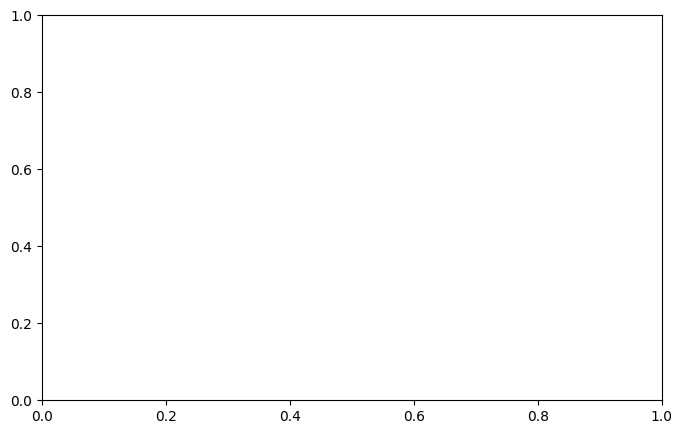

: 

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd # Using pandas for easier CSV reading
import re # Already imported, good for string parsing if needed

# === Configuration ===
FILENAME = "temperature_pwm_log_2.csv" # Your new log file

# === Load Data from File using pandas ===
try:
    df = pd.read_csv(FILENAME)
    # Ensure columns are numeric for plotting
    df['Time Elapsed (s)'] = pd.to_numeric(df['Time Elapsed (s)'], errors='coerce')
    df['Measured Temp (°C)'] = pd.to_numeric(df['Measured Temp (°C)'], errors='coerce')
    df['PWM Output'] = pd.to_numeric(df['PWM Output'], errors='coerce')
    df['Target Temp (°C)'] = pd.to_numeric(df['Target Temp (°C)'], errors='coerce')

    # Drop any rows where critical columns (time, temp, pwm) are NaN after coercion
    df.dropna(subset=['Time Elapsed (s)', 'Measured Temp (°C)', 'PWM Output', 'Target Temp (°C)'], inplace=True)

except FileNotFoundError:
    print(f"Error: The file '{FILENAME}' was not found. Please ensure the logging script ran and created it.")
    exit()
except Exception as e:
    print(f"Error reading or parsing CSV file: {e}")
    exit()

# === Plot Temperature and PWM vs Time ===
fig, ax1 = plt.subplots(figsize=(8, 5))

# Plot Temperature on ax1
ax1.plot(df['Time Elapsed (s)'], df['Measured Temp (°C)'], marker="o", linestyle="-", color="b", label="Measured Temperature (°C)", markersize=4)
ax1.plot(df['Time Elapsed (s)'], df['Target Temp (°C)'], linestyle="--", color="gray", label="Target Temperature (°C)")
ax1.set_xlabel("Time Elapsed (s)")
ax1.set_ylabel("Temperature (°C)", color="b")
ax1.tick_params(axis='y', labelcolor="b")
ax1.grid(True)

# Create a second Y-axis for PWM on the same X-axis
ax2 = ax1.twinx()
ax2.plot(df['Time Elapsed (s)'], df['PWM Output'], marker="x", linestyle="-", color="r", label="PWM Output", markersize=4)
ax2.set_ylabel("PWM Output (0-100 PID Units)", color="r")
ax2.tick_params(axis='y', labelcolor="r")

# Title and Legend
plt.title("Temperature and PWM Output vs. Time")

# Combine legends from both axes
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='lower right')

plt.tight_layout() # Adjust layout to prevent labels overlapping
plt.show()

# You can also print the first few rows of the DataFrame to inspect data
print("\nFirst 5 rows of the loaded data:")
print(df.head())

In [2]:
pip install re


Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement re (from versions: none)
ERROR: No matching distribution found for re
